# import libraries

In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
import os
import datetime
import IPython
import IPython.display
import matplotlib as mpl
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import LSTM, Dense, Input
from sklearn.metrics import confusion_matrix


# Generate Dataset

## Read data
Chia (70%, 20%, 10%) cho các tập huấn luyện, xác thực và thử nghiệm.

In [13]:
train_df = pd.read_csv('./processed_data/trainset.csv')
val_df = pd.read_csv('./processed_data/valset.csv')
test_df = pd.read_csv('./processed_data/testset.csv')

date_time = pd.to_datetime(test_df.pop('Formatted Date'), format='%Y-%m-%d %H:%M:%S.%f %z')
train_df.drop(['Formatted Date'],axis=1,inplace=True)
val_df.drop(['Formatted Date'],axis=1,inplace=True)

# Parameter

In [14]:
n_timestep = 15
n_timepred = 1
n_feature = len(train_df.columns)

## Scale


In [15]:
from sklearn.preprocessing import MinMaxScaler

In [16]:
scaler = MinMaxScaler()
train_df = scaler.fit_transform(train_df)
val_df = scaler.fit_transform(val_df)
test_df = scaler.fit_transform(test_df)

### Splitting

In [17]:
def timestep_split(data, n_step):
    x, y = [], []

    length = len(data)
    for i in range(n_step, length):
        x.append(data[i-n_step:i])
        y.append(data[i])
    return np.array(x), np.array(y)

In [18]:
x_train, y_train = timestep_split(data=train_df, n_step=n_timestep)
x_val, y_val = timestep_split(data=val_df, n_step=n_timestep)
x_test, y_test = timestep_split(data=test_df, n_step=n_timestep)

In [19]:
x_train[0], y_train[0]

(array([[0.        , 0.36288363, 0.35291194, 0.89      , 0.62      ,
         0.51659076, 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.        , 0.        , 0.        ,
         1.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.        , 0.34938665, 0.63960519,
         0.37059048, 0.98296291, 0.50196398, 0.99999614],
        [0.        , 0.37233372, 0.36500704, 0.85      , 0.615     ,
         0.50829538, 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.        , 1.        , 0.        ,
         0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.        , 

# Build model LSTM

In [20]:
model = keras.models.Sequential()

model.add(Input(shape=(n_timestep,n_feature), name='Input'))

model.add(LSTM(units=64,
               activation='tanh',
               recurrent_activation='sigmoid',
               use_bias=True,
               kernel_initializer='glorot_uniform',
               recurrent_initializer='orthogonal',
               bias_initializer='zeros',
               dropout=0.0,
               recurrent_dropout=0.0,
               return_sequences=True,
               name='LSTM_many_to_many'))

model.add(LSTM(units=64,
               activation='tanh',
               recurrent_activation='sigmoid',
               use_bias=True,
               kernel_initializer='glorot_uniform',
               recurrent_initializer='orthogonal',
               bias_initializer='zeros',
               dropout=0.0,
               recurrent_dropout=0.0,
               name='LSTM_many_to_one'))

model.add(Dense(units=n_feature,
                activation='sigmoid',
                use_bias=True,
                kernel_initializer='glorot_uniform',
                bias_initializer='zeros',
                name='Output_layer'))

opt = tf.keras.optimizers.Adam(learning_rate=0.001,
                               beta_1=0.9,
                               beta_2=0.999,
                               epsilon=1e-08)

model.compile(optimizer=opt, loss='mse')

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 LSTM_many_to_many (LSTM)    (None, 15, 64)            26624     
                                                                 
 LSTM_many_to_one (LSTM)     (None, 64)                33024     
                                                                 
 Output_layer (Dense)        (None, 39)                2535      
                                                                 
Total params: 62,183
Trainable params: 62,183
Non-trainable params: 0
_________________________________________________________________


2023-07-03 22:17:20.397060: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-07-03 22:17:20.397997: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-07-03 22:17:20.398677: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

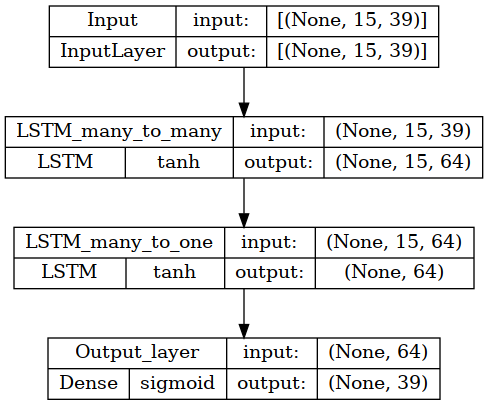

In [21]:
tf.keras.utils.plot_model(model,to_file='./image/model_LSTM.png', show_layer_activations=True, show_shapes=True, show_layer_names=True)


# Train

In [22]:
path = './model/LSTM_model_15timesteps.h5'
checkpoint = keras.callbacks.ModelCheckpoint(filepath=path, monitor='val_loss', save_best_only=True)

In [23]:
model.fit(x_train, y_train, epochs = 75, verbose=0, callbacks=[checkpoint], batch_size=256,validation_data=(x_val, y_val), validation_batch_size=256)

2023-07-03 22:17:21.057357: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-07-03 22:17:21.059197: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-07-03 22:17:21.060090: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

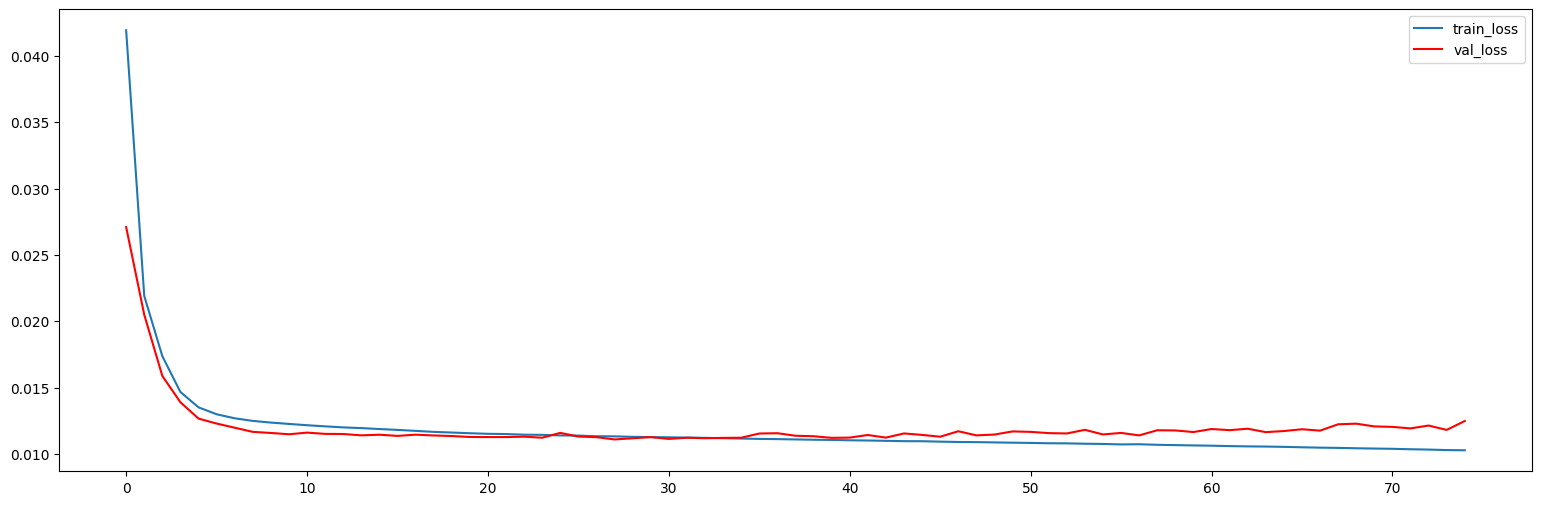

In [24]:
plt.figure(figsize=(19, 6))
plt.plot(model.history.history['loss'], label='train_loss')
plt.plot(model.history.history['val_loss'], c='red', label='val_loss')
plt.legend()

# Evaluate

In [25]:
#load best model
model = keras.models.load_model(path)

2023-07-03 22:47:45.038358: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-07-03 22:47:45.039293: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-07-03 22:47:45.040117: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

In [26]:
y_predict = model.predict(x_test)

y_predict_inverse = scaler.inverse_transform(y_predict)
y_test_inverse = scaler.inverse_transform(y_test)

2023-07-03 22:47:45.431271: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-07-03 22:47:45.432545: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-07-03 22:47:45.434035: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

297/297 [==============================] - 4s 12ms/step


In [27]:
y_predict_inverse[0]

array([ 2.0062155e-03,  1.4827740e+01,  1.4121624e+01,  5.3160793e-01,
        1.1901350e+01,  1.0283844e+03,  1.0078490e-03,  1.1303014e-03,
        1.6731413e-03,  8.2213376e-03,  3.3751428e-03,  2.5319394e-02,
        4.9097139e-02,  8.2235341e-04,  7.8623364e-04,  1.7537344e-03,
        1.2777032e-03,  2.3453594e-03,  1.2544524e-03,  1.3871574e-03,
        1.1369301e-03,  1.0135353e-03,  1.5126554e-03,  6.0498025e-02,
        4.1414639e-03,  8.9037877e-01,  1.4902878e-03,  1.6339453e-03,
        6.7570084e-04,  1.0214982e-03,  2.3260433e-03,  1.5864854e-03,
        9.7058713e-04,  8.1714191e+00,  2.3596716e+00,  5.2615333e-01,
       -8.4939557e-01, -9.3629599e-01, -4.4755576e-05], dtype=float32)

In [28]:
y_test_inverse[0]

array([ 0.00000000e+00,  1.70833333e+01,  1.70833333e+01,  4.80000000e-01,
        9.98200000e+00,  1.03046000e+03,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  1.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  4.14563577e-01,  7.91034427e+00,  5.00000000e-01,
       -8.66025404e-01, -9.99972932e-01, -7.35770473e-03])

## Precip Type

In [29]:
rain = y_predict_inverse[:,0] < 0.5
snow = y_predict_inverse[:,0] >= 0.5
y_predict_inverse[rain,0] = 0
y_predict_inverse[snow,0] = 1

In [30]:
BA = keras.metrics.BinaryAccuracy(threshold=0.5)
BA.update_state(y_test_inverse[:,0], y_predict_inverse[:,0])
R_Accuracy = float(BA.result())
print('Độ chính xác khi dự đoán mưa hay không: {:.2f}%'.format(R_Accuracy*100))

Độ chính xác khi dự đoán mưa hay không: 98.03%


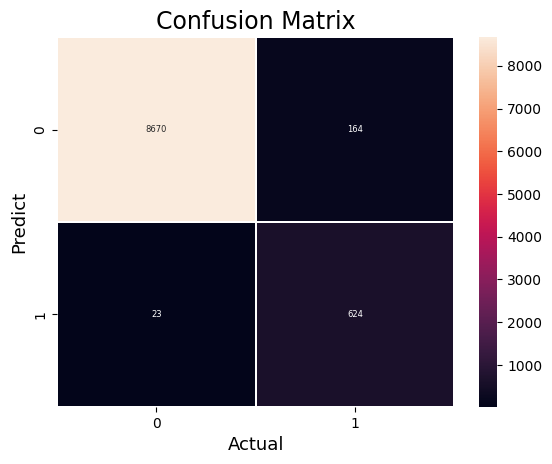

In [31]:
# compute the confusion matrix
cm = confusion_matrix(y_test_inverse[:,0], y_predict_inverse[:,0])
 
#Plot the confusion matrix.
sns.heatmap(cm,
            annot=True,
            fmt='g',
            linewidths= 0.2,
            annot_kws={"size": 6})
plt.xlabel('Actual',fontsize=13)
plt.ylabel('Predict',fontsize=13)
plt.title('Confusion Matrix',fontsize=17)

plt.show()

## Temperature

In [32]:
from keras.metrics import mean_absolute_error

In [33]:
# mean absolute error
mean = float(mean_absolute_error(y_test_inverse[:,1], y_predict_inverse[:,1]))
print('Độ lệch trung bình là: {:.3f}'.format(mean))

Độ lệch trung bình là: 1.802


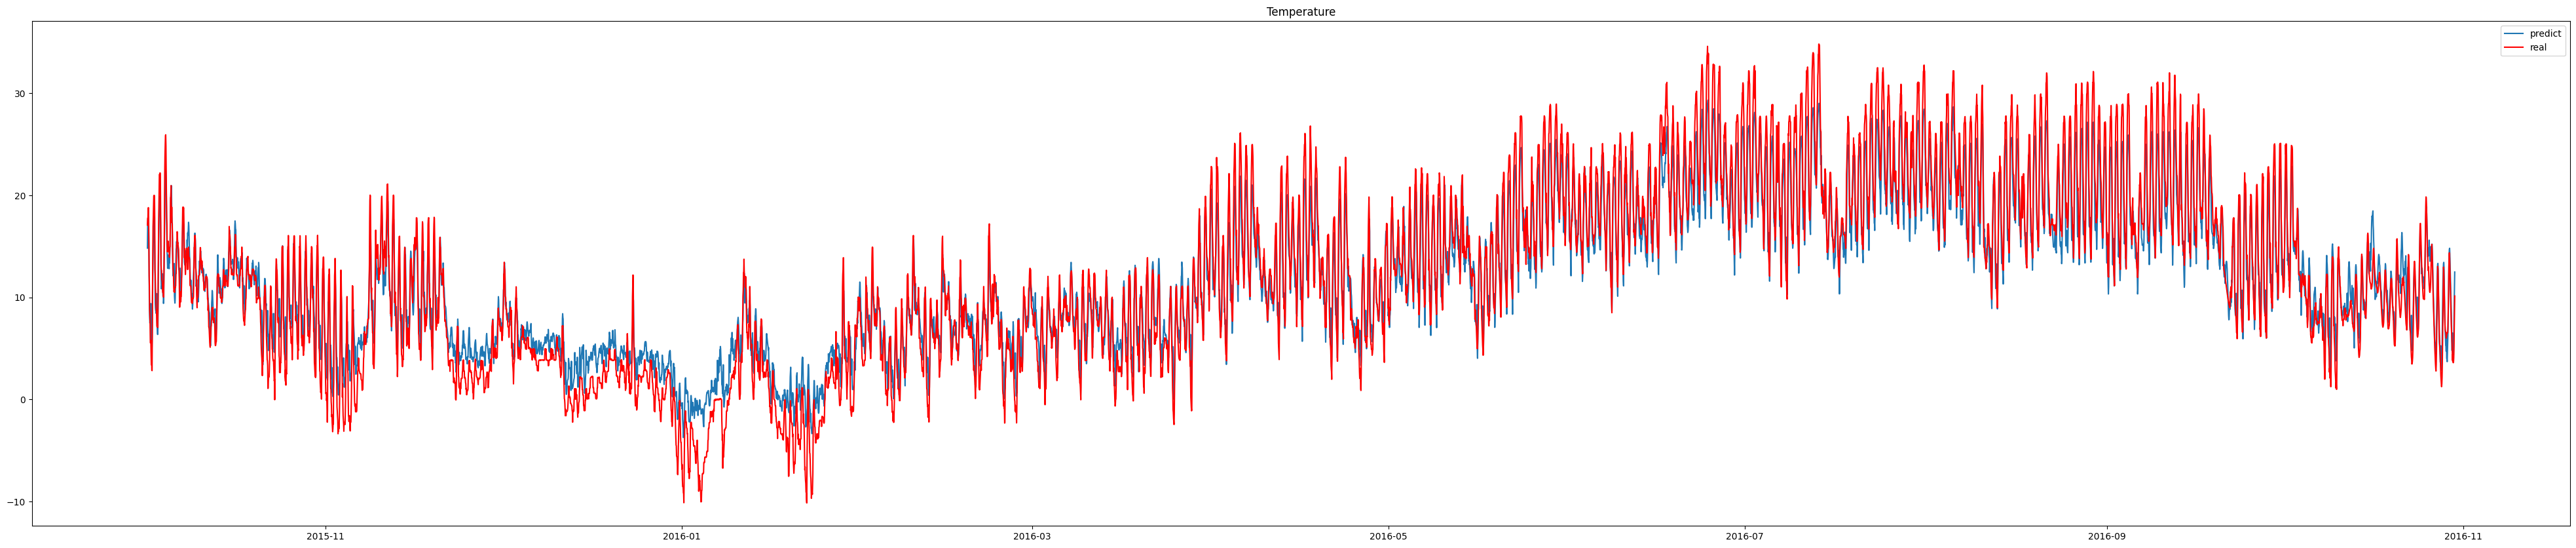

In [37]:
#visualization
plt.figure(figsize=(50,10))
plt.plot(date_time[n_timestep:], y_predict_inverse[:,1], label='predict')
plt.plot(date_time[n_timestep:], y_test_inverse[:,1], c='red', label='real')
plt.title('Temperature')
plt.legend()

## Apparent Temperature

In [38]:
# mean absolute error
mean = float(mean_absolute_error(y_test_inverse[:,2], y_predict_inverse[:,2]))
print('Độ lệch trung bình là: {:.3f}'.format(mean))

Độ lệch trung bình là: 1.628


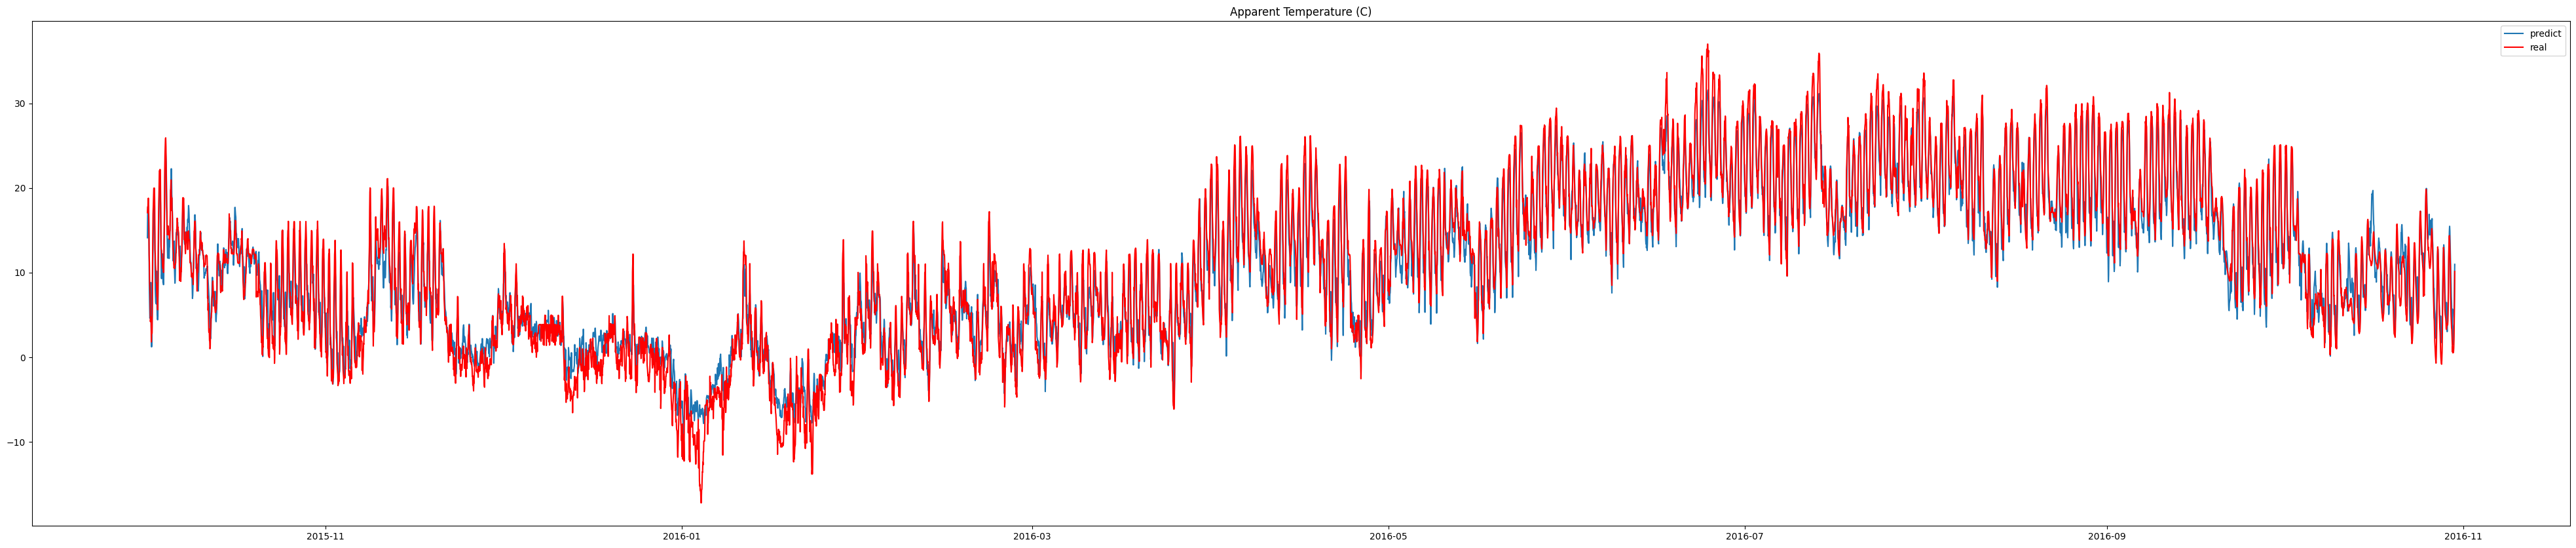

In [41]:
#visualization
plt.figure(figsize=(50,10))
plt.plot(date_time[n_timestep:], y_predict_inverse[:,2], label='predict')
plt.plot(date_time[n_timestep:], y_test_inverse[:,2], c='red', label='real')
plt.title('Apparent Temperature (C)')
plt.legend()

## Humidity

In [42]:
# mean absolute error
mean = float(mean_absolute_error(y_test_inverse[:,3], y_predict_inverse[:,3]))
print('Độ lệch trung bình là: {:.3f}'.format(mean))

Độ lệch trung bình là: 0.043


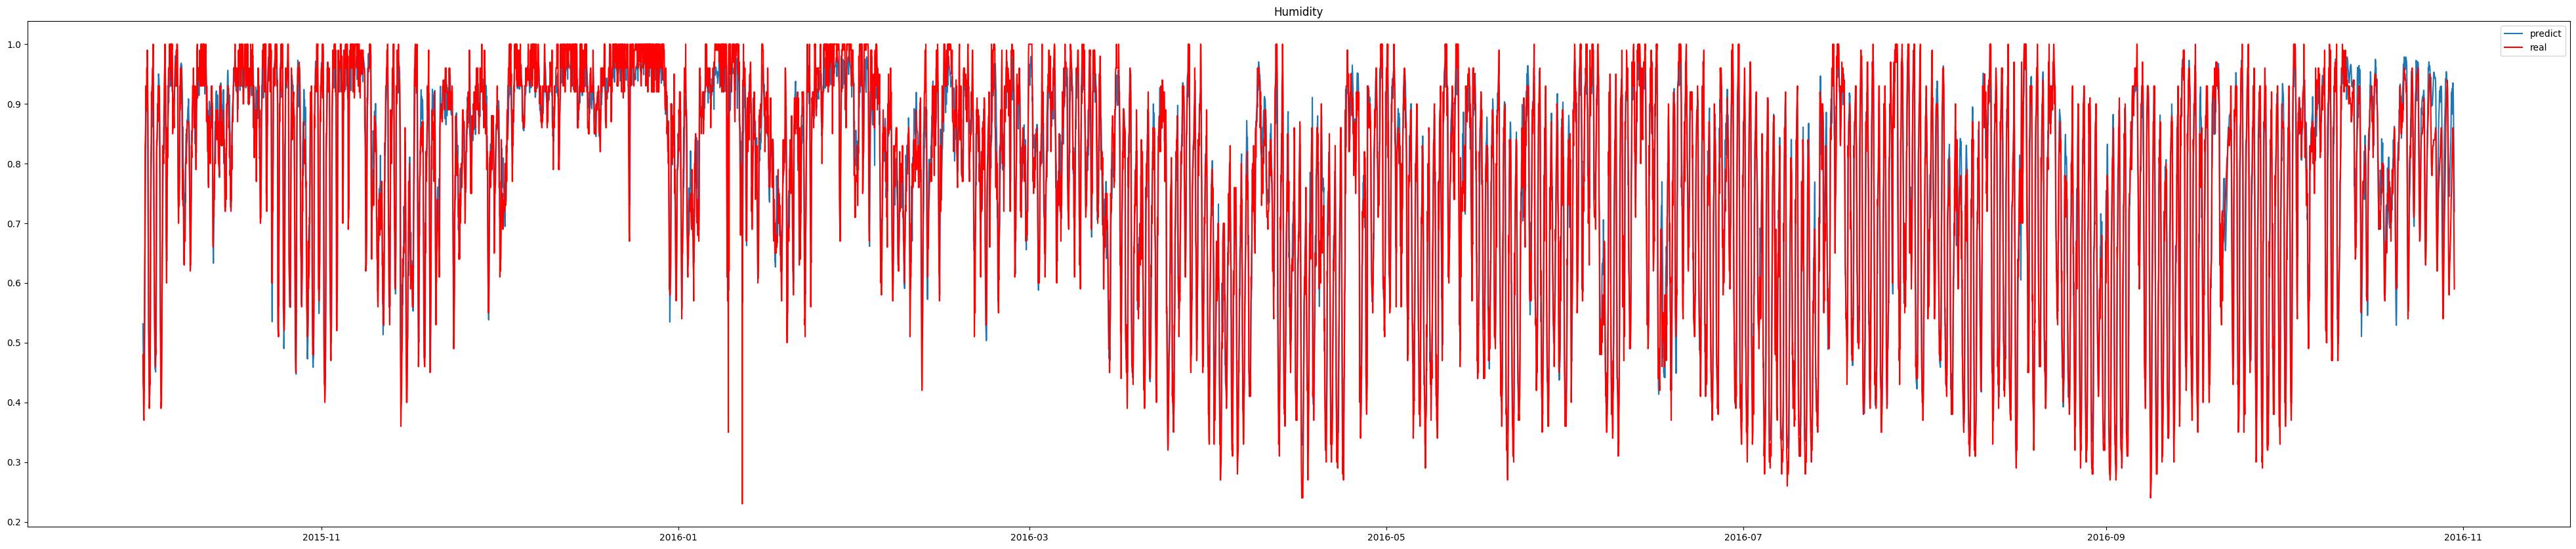

In [43]:
#visualization
plt.figure(figsize=(50,10))
plt.plot(date_time[ n_timestep:], y_predict_inverse[:,3], label='predict')
plt.plot(date_time[ n_timestep:], y_test_inverse[:,3], c='red', label='real')
plt.title('Humidity')
plt.legend()

## Visibility

In [44]:
# mean absolute error
mean = float(mean_absolute_error(y_test_inverse[:,4], y_predict_inverse[:,4]))
print('Độ lệch trung bình là: {:.3f}'.format(mean))

Độ lệch trung bình là: 1.929


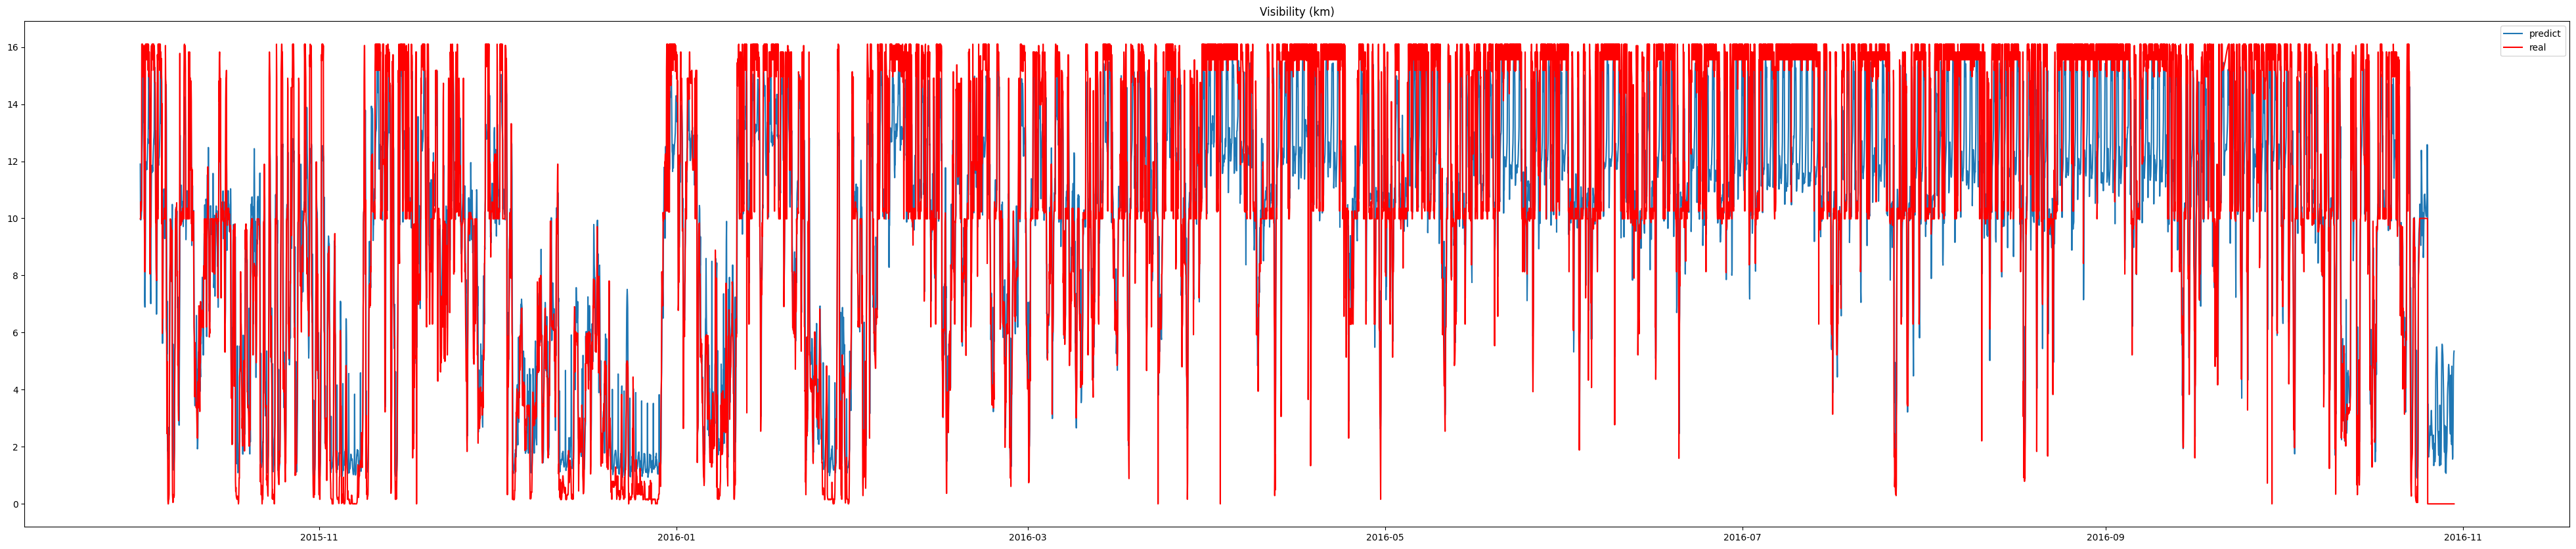

In [45]:
#visualization
plt.figure(figsize=(50,10))
plt.plot(date_time[n_timestep:], y_predict_inverse[:,4], label='predict')
plt.plot(date_time[n_timestep:], y_test_inverse[:,4], c='red', label='real')
plt.title('Visibility (km)')
plt.legend()

## Pressure

In [46]:
# mean absolute error
mean = float(mean_absolute_error(y_test_inverse[:,5], y_predict_inverse[:,5]))
print('Độ lệch trung bình là: {:.3f}'.format(mean))

Độ lệch trung bình là: 1.465


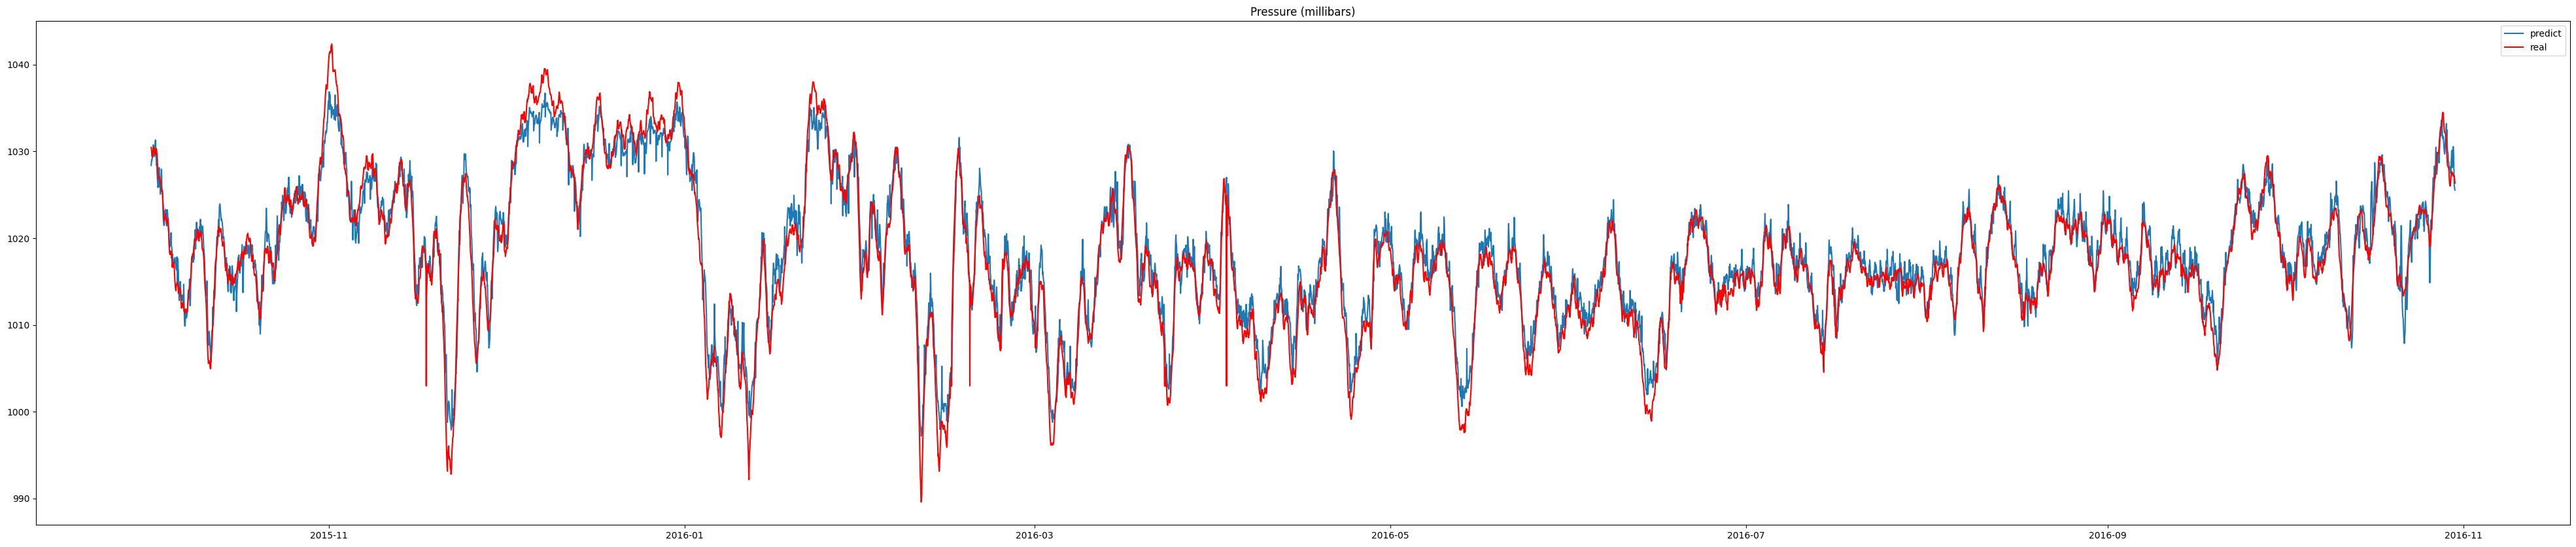

In [47]:
#visualization
plt.figure(figsize=(50,10))
plt.plot(date_time[n_timestep:], y_predict_inverse[:,5], label='predict')
plt.plot(date_time[n_timestep:], y_test_inverse[:,5], c='red', label='real')
plt.title('Pressure (millibars)')
plt.legend()

## Summary

In [48]:
max_indices_pre = np.argmax(y_predict_inverse[:, 6:33], axis=1)
print(max_indices_pre)

[19 19 19 ...  6  6  6]


In [49]:
max_indices_test = np.argmax(y_test_inverse[:, 6:33], axis=1)
print(max_indices_test)

[19 19 19 ...  6  6  6]


In [50]:
from sklearn.metrics import accuracy_score
accuracy_score( max_indices_test,max_indices_pre)

0.7757620504166227

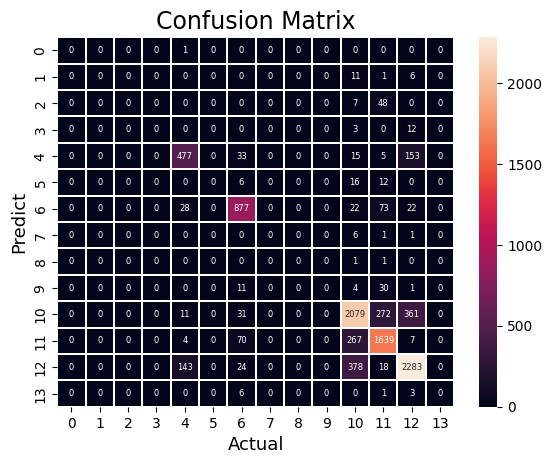

In [51]:
# compute the confusion matrix
cm = confusion_matrix(max_indices_test,max_indices_pre)
 
#Plot the confusion matrix.

sns.heatmap(cm,
            annot=True,
            fmt='g',
            linewidths= 0.2,
            annot_kws={"size": 6})
# plt.figure(figsize= (5, 5))
plt.xlabel('Actual',fontsize=13)
plt.ylabel('Predict',fontsize=13)
plt.title('Confusion Matrix',fontsize=17)

plt.show()

## Wind Speed (km/h) And Wind Bearing (degrees)

In [52]:
def convertWind(wx, wy):
    # Chuyển đổi Wx và Wy về 'Wind Speed (km/h)'
    w_speed = np.sqrt(wx**2 + wy**2)
   
    # Chuyển đổi Wx và Wy về 'Wind Bearing (degrees)'
    w_bearing = np.arctan2(wy, wx) * 180 / np.pi
    return w_speed, w_bearing

In [53]:
w_speed_test, w_bearing_test = convertWind(y_test_inverse[:,33], y_test_inverse[:,34])
w_speed_pred, w_bearing_pred = convertWind(y_predict_inverse[:,33], y_predict_inverse[:,34])


In [54]:
# mean absolute error
mean = float(mean_absolute_error(w_speed_test, w_speed_pred))
print('Độ lệch trung bình là: {:.3f}'.format(mean))

Độ lệch trung bình là: 3.275


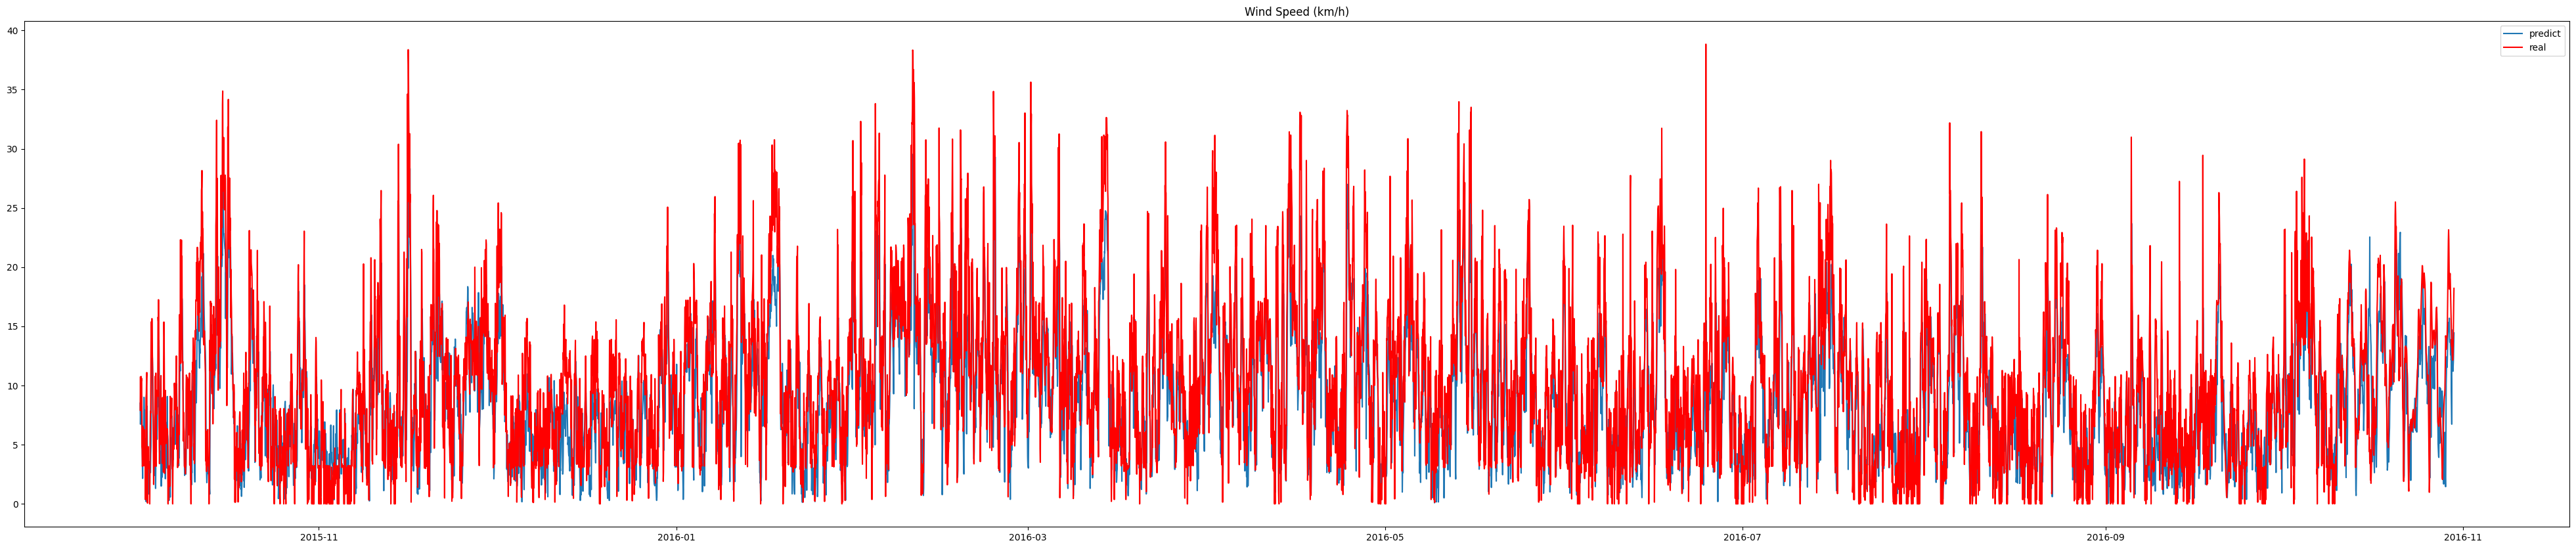

In [55]:
#visualization
plt.figure(figsize=(50,10))
plt.plot(date_time[n_timestep:], w_speed_pred, label='predict')
plt.plot(date_time[n_timestep:], w_speed_test, c='red', label='real')
plt.title('Wind Speed (km/h)')
plt.legend()

In [56]:
# mean absolute error
mean = float(mean_absolute_error(w_bearing_test, w_bearing_pred))
print('Độ lệch trung bình là: {:.3f}'.format(mean))

Độ lệch trung bình là: 54.232


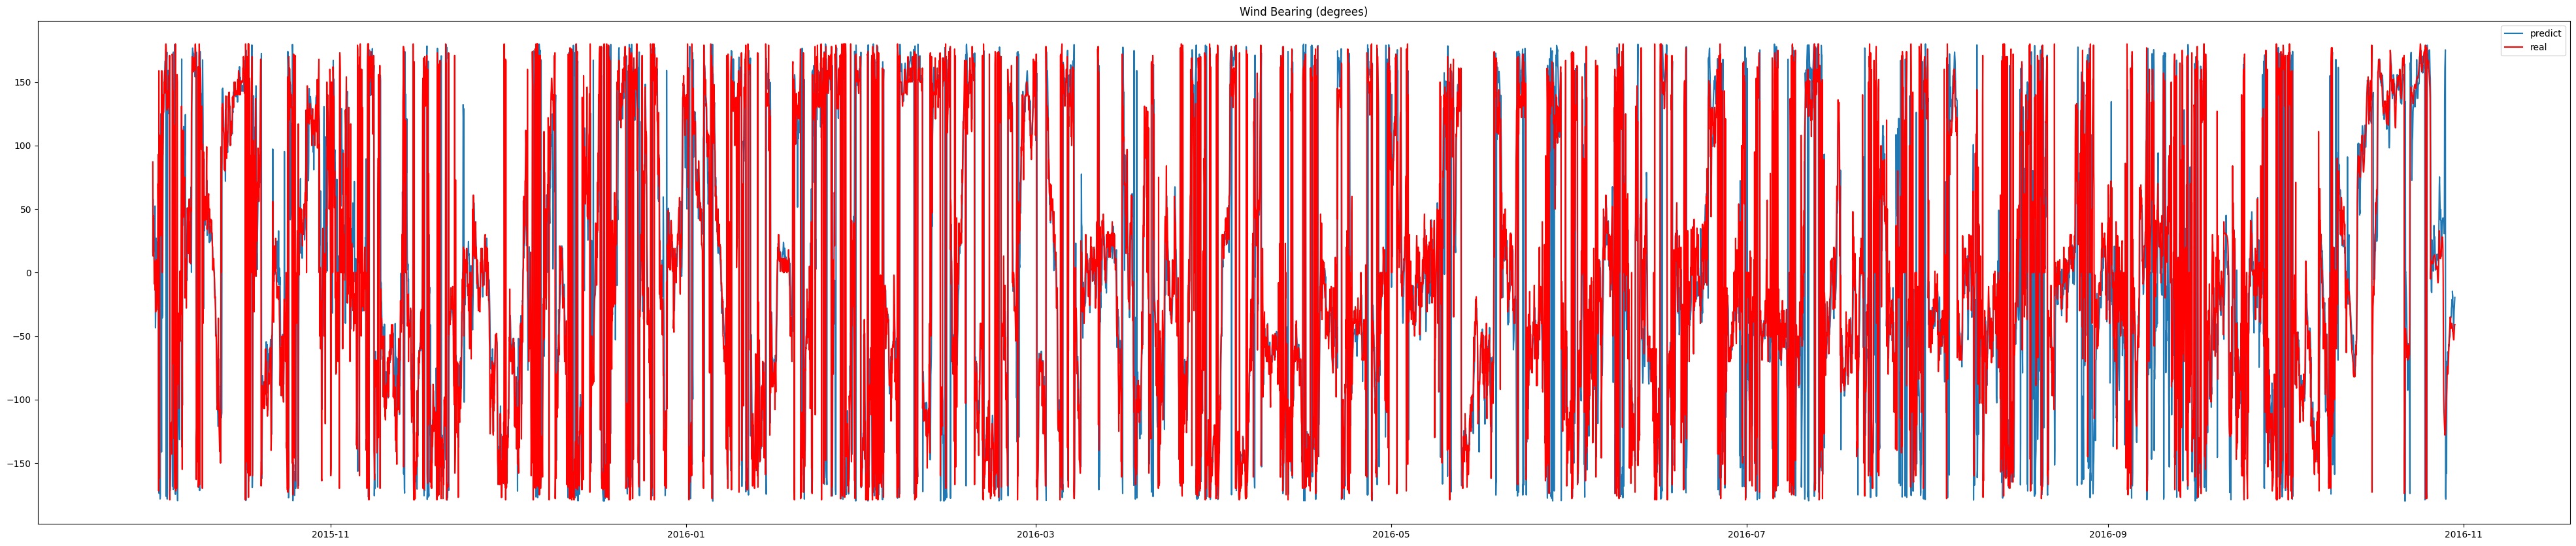

In [57]:
#visualization
plt.figure(figsize=(50,10))
plt.plot(date_time[n_timestep:], w_bearing_pred, label='predict')
plt.plot(date_time[n_timestep:], w_bearing_test, c='red', label='real')
plt.title('Wind Bearing (degrees)')
plt.legend()